In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage
import cv2
import glob
import pandas as pd
import joblib

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import data, io,color
from skimage.io import imread_collection #loads a collection of images
from skimage.io import imread, imshow
from pathlib import Path

from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt

import sys

### Load model1

In [2]:
reconstructed_model = load_model("my_model_tf")

In [3]:
#def init():
    #CHANGE THIS TO YOUR TRAIN FOLDER
image_folder = 'C:/Study/Semester2/Machine Learning/ML_images/Training' 
#image_folder = 'C:/Users/danie/Desktop/Training_ML'
TOO_SMALL = 200000
SMALL = 500000
MEDIUM = 1200000
LARGE = 2100000
    
X_train = []
Y_train = []
counter = 1
    
img_height = 1888 #Usually 128. this might change depending on Annaya & Danielle's input 
img_width = 1888 #Usually 128. this might change depending on Annaya & Danielle's input 
epochs = 10 #Start with 1, and increase to 10, 100, 500, 1000 and 3000. 11 is the recommended number of runs through the training dataset. We will probably have to tune this. 
#total_training = total number of training data len()
batch_size = 1 #test different ones from 1 to 2, 5, 10, etc
total_images = 1

In [4]:
#Define sizes of images based on their resolution
#Image shape and resolution

#TODO make the IMG sizes make sense


def shape(img):
    size = 0
    resolution = img.shape[0] * img.shape[1]
    if resolution <= TOO_SMALL:
        size = 0
    elif resolution <= SMALL:
        size = 1
    elif resolution <= MEDIUM:
        size = 2
    elif resolution <= LARGE:
        size = 3
    else:
        size = 6
    return size
def create_dataframe(image_folder):
    images = Path(image_folder).glob('*.jpg')

    list_of_files = []
    for image in images:
        list_of_files.append(str(image))

    df = pd. DataFrame(list_of_files, columns = ["image_path"])
    df_length = len(df.index)
    print("processing", df_length, "photos for training")
    
    height= []
    width = []
    resolution = []
    
    for image_path in df['image_path']:
        img = cv2.imread(str(image_path))
        height.append(img.shape[0])
        width.append(img.shape[1])
        
    df["height"] = height
    df["width"] = width
    df["resolution"] = df["height"] * df["width"]
    
    df = df[df.resolution < LARGE]
    
    ll = df_length - len(df.index)
    print("dropped ", ll, "photos because they were too large to process")
    
    df = df[df.resolution > TOO_SMALL]
    
    ss = df_length - len(df.index) - ll
    print("dropped ", ss, "photos because they were too small to process")
    df.head()
    
    return df
#PCA rgb then pass to prep_img as an rgb image

def pca_rgb(imgBGR, size): #imgRGB, size
    b,g,r = cv2.split(imgBGR)
    list_channels = [b,g,r]
    
    #check size first
    if size ==1:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 300)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)    

    elif size == 2:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 400)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
    else:
        inverted_img = []
        for c in list_channels:            
            pca = PCA(n_components = 500)
            transformed = pca.fit_transform(c/255) #r_scaled
            inverted = pca.inverse_transform(transformed)
            inverted_img.append(inverted)
        
        tuple(inverted_img)
        RGB_compressed = cv2.merge(inverted_img)
        
    RGB_compressed = np.float32(RGB_compressed)
        
    return RGB_compressed

# image padding

def rgb_pad(image):
    
    height = image.shape[0]
    width = image.shape[1]

    WHITE = [255,255,255] #[255,255,255]  1, 1, 1
    MAX = 1888
    
    if height % 2 == 0:
        top = int((MAX - height)/ 2)
        bottom = int((MAX - height)/ 2)
    else: 
        top = int((MAX - (height-1))/ 2)
        bottom = int(((MAX - (height-1))/ 2)-1)

    if width % 2 == 0:
        left = int((MAX - width)/ 2)
        right = int((MAX - width)/ 2)
    else: 
        left = int((MAX - (width-1))/ 2)
        right = int(((MAX - (width-1))/2)-1)
    
    image = cv2.copyMakeBorder(image, top, bottom, left, right,
    cv2.BORDER_CONSTANT,value=WHITE)

    return image
def prep_img(img_path):
    imgRGB = cv2.imread(img_path)
    imgBGR = np.flip(imgRGB, -1)
    
    #check the image category by 'shape' function
    image_size_category = shape(imgBGR) #imgRGB
    #print("image size determined!")

    if image_size_category <1:
        raise Exception("Your image is too small to be used")
    elif image_size_category >4:
        raise Exception("Your image is too big to be used")

    #print("image PCA started!")
    #image_pca = pca_rgb(imgRGB, image_size_category) 
    RGB_compressed = pca_rgb(imgBGR, image_size_category) #imgRGB, image_size_category
    #RGB_compressed[400][400]
    #plt.figure(figsize=(10, 10))
    #plt.imshow(RGB_compressed)
    
    print("image is padded")
    padded_image = rgb_pad(RGB_compressed)
    #padded_image[1000][1000]
    #plt.figure(figsize=(10, 10))
    #plt.imshow(padded_image)
    
    #image_pca = np.float32((1.0/255)*image_pca) # #The rgb_compressed come out in RGB scaled data already
    print("image converted to LAB")
    padded_LAB = cv2.cvtColor(padded_image, cv2.COLOR_RGB2Lab) #convert padded RGB compressed to LAB
    padded_LAB = padded_LAB/np.amax(padded_LAB) #scaled to -1/1
    #imgLAB = np.clip(imgLAB, 0, 1)

    
    #separate L and AB color channels
    Y = padded_LAB[:, :,1:]
    #Y = Y / 128 #comment out when show predicted
    #Y = Y.tolist()
    X = padded_LAB[:, :, 0] #.tolist()
    #print(X[1000])
    #plt.figure(figsize=(10, 10))
    #plt.imshow(X)
    
    #this is in sample code and idk why
    
    X = X.reshape(1, 1888, 1888, 1) #comment out when show predicted
    Y = Y.reshape(1, 1888, 1888, 2) #comment out when show predicted
    
    print("image processed")

    return Y, X 
#Debugged function
def prep_img(img_path):
    imgRGB = cv2.imread(img_path)
    imgBGR = np.flip(imgRGB, -1)
    
    #check the image category by 'shape' function
    image_size_category = shape(imgBGR) #imgRGB
    #print("image size determined!")

    if image_size_category <1:
        raise Exception("Your image is too small to be used")
    elif image_size_category >4:
        raise Exception("Your image is too big to be used")

    #print("image PCA started!")
    #image_pca = pca_rgb(imgRGB, image_size_category) 
    RGB_compressed = pca_rgb(imgBGR, image_size_category) #imgRGB, image_size_category
    #RGB_compressed[400][400]
    #plt.figure(figsize=(10, 10))
    #plt.imshow(RGB_compressed)
    
    print("image is padded")
    padded_image = rgb_pad(RGB_compressed)
    #padded_image[1000][1000]
    #plt.figure(figsize=(10, 10))
    #plt.imshow(padded_image)
    
    #image_pca = np.float32((1.0/255)*image_pca) # #The rgb_compressed come out in RGB scaled data already
    print("image converted to LAB")
    padded_LAB = cv2.cvtColor(padded_image, cv2.COLOR_RGB2Lab) #convert padded RGB compressed to LAB
    padded_LAB = padded_LAB/np.amax(padded_LAB) #scaled to -1/1
    #imgLAB = np.clip(imgLAB, 0, 1)

    
    #separate L and AB color channels
    Y = padded_LAB[:, :,1:]
    #Y = Y / 128 #comment out when show predicted
    #Y = Y.tolist()
    X = padded_LAB[:, :, 0] #.tolist()
    #print(X[1000])
    #plt.figure(figsize=(10, 10))
    #plt.imshow(X)
    
    #this is in sample code and idk why
    
    X = X.reshape(1, 1888, 1888, 1) #comment out when show predicted
    Y = Y.reshape(1, 1888, 1888, 2) #comment out when show predicted
    
    print("image processed")

    return Y, X 


### Start testing

In [252]:
test_path = "C:/Study/Semester2/Machine Learning/ML_images/gray/g41.jpg"

In [253]:
def prep_img_test(img_path):
    imgRGB = cv2.imread(img_path)
    imgBGR = np.flip(imgRGB, -1)
    
    #check the image category by 'shape' function
    image_size_category = shape(imgBGR) #imgRGB
    #print("image size determined!")

    if image_size_category <1:
        raise Exception("Your image is too small to be used")
    elif image_size_category >4:
        raise Exception("Your image is too big to be used")

    #print("image PCA started!")
    #image_pca = pca_rgb(imgRGB, image_size_category) 
    RGB_compressed = pca_rgb(imgBGR, image_size_category)
    RGB_compressed = np.clip(RGB_compressed, 0, 1)
    print('RGB compressed :',np.min(RGB_compressed),np.max(RGB_compressed))
    #plt.figure(figsize=(10, 10))
    #plt.imshow(RGB_compressed)
    
    print("image is padded")
    padded_RGB = rgb_pad(RGB_compressed)
    print(padded_RGB.shape)
    padded_RGB = np.float32(padded_RGB*(1/255))
    print('padded_RGB:', np.min(padded_RGB),np.max(padded_RGB))
   
    plt.figure(figsize=(10, 10))
    plt.imshow(padded_RGB*255)
    
    print("image converted to LAB")
    #padded_LAB = cv2.cvtColor(padded_RGB, cv2.COLOR_RGB2Lab) #convert padded RGB compressed to L
    
    padded_LAB = color.rgb2lab(padded_RGB)
    #padded_LAB = padded_LAB/128
    print('padded_LAB:', np.min(padded_LAB),np.max(padded_LAB))
    print(padded_LAB.shape)
    #padded_LAB = padded_LAB/np.amax(padded_LAB) #scaled to -1/1
   

    
    #separate L and AB color channels
    Y = padded_LAB[:, :,1:]
    #Y = Y /128
    print('A :',np.min(Y[:,:,0]), np.max(Y[:,:,0]))
    print('B :',np.min(Y[:,:,1]), np.max(Y[:,:,1]))
    
    X = padded_LAB[:, :, 0] #X is in a color scale 0 to 100
    print('X :',np.min(X), np.max(X))
    
    #this is in sample code and idk why
    
    X = X.reshape(1, 1888, 1888, 1) #comment out when show predicted
    Y = Y.reshape(1, 1888, 1888, 2) #comment out when show predicted
    
    print("image processed")

    return Y, X 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RGB compressed : 0.0029012568 1.0
image is padded
(1888, 1888, 3)
padded_RGB: 1.1377479e-05 1.0
image converted to LAB
padded_LAB: -0.00936538 100.0
(1888, 1888, 3)
A : -0.00936538 0.015310943
B : -0.0070363283 0.0338614
X : 0.0017337799 100.0
image processed


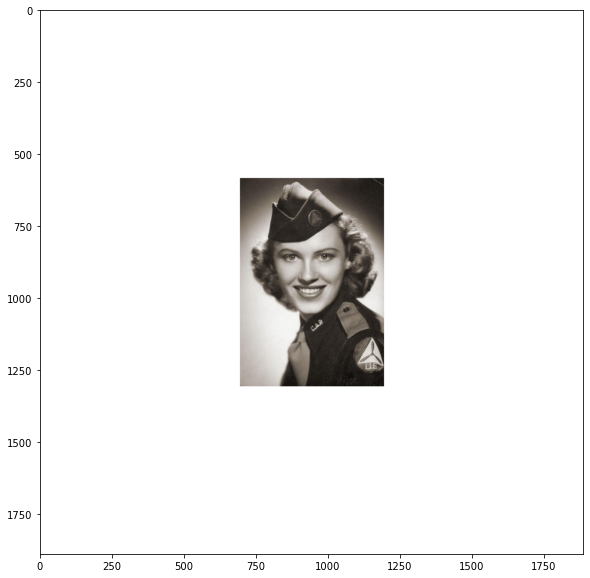

In [254]:
CL, BW = prep_img_test(test_path)
#test_data = tf.data.Dataset.from_tensor_slices(BW)
test_predict = reconstructed_model.predict(BW) #what shape does the prediction takes?

In [255]:
test_predict.shape

(1, 1888, 1888, 2)

In [256]:
test_predict_reshaped= test_predict[0,:,:,:]

In [257]:
test_predict_reshaped.shape

(1888, 1888, 2)

In [258]:
print(np.min(test_predict_reshaped), np.max(test_predict_reshaped)) #it predict a little bit of colors

-0.99908423 0.19854021


In [259]:
#DF channel A
df_A = pd.DataFrame(test_predict_reshaped[:,:,0]) 
df_A.describe()

,0,1,2,3,4,5,6,7,8,9,...,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887
count,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,...,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000
mean,-0.981491,-0.981491,-0.981491,-0.981491,-0.981491,-0.981491,-0.981491,-0.981491,-0.981491,-0.981491,...,-0.995015,-0.995015,-0.993052,-0.993052,-0.991297,-0.991297,-0.950987,-0.950987,-0.817652,-0.817652
std,0.013730,0.013730,0.013730,0.013730,0.013730,0.013730,0.013730,0.013730,0.013730,0.013730,...,0.018291,0.018291,0.016008,0.016008,0.018565,0.018565,0.022193,0.022193,0.026448,0.026448
min,-0.992169,-0.992169,-0.992169,-0.992169,-0.992169,-0.992169,-0.992169,-0.992169,-0.992169,-0.992169,...,-0.995683,-0.995683,-0.993672,-0.993672,-0.992061,-0.992061,-0.952109,-0.952109,-0.829871,-0.829871
25%,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,...,-0.995683,-0.995683,-0.993672,-0.993672,-0.992061,-0.992061,-0.952109,-0.952109,-0.818919,-0.818919
50%,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,...,-0.995683,-0.995683,-0.993672,-0.993672,-0.992061,-0.992061,-0.952109,-0.952109,-0.818919,-0.818919
75%,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,-0.981944,...,-0.995683,-0.995683,-0.993672,-0.993672,-0.992061,-0.992061,-0.952109,-0.952109,-0.818919,-0.818919
max,-0.560403,-0.560403,-0.560403,-0.560403,-0.560403,-0.560403,-0.560403,-0.560403,-0.560403,-0.560403,...,-0.436301,-0.436301,-0.505264,-0.505264,-0.432748,-0.432748,-0.317205,-0.317205,-0.084584,-0.084584


In [260]:
df_B = pd.DataFrame(test_predict_reshaped[:,:,1]) 
df_B.describe()

,0,1,2,3,4,5,6,7,8,9,...,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887
count,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,...,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000,1888.000000
mean,-0.998543,-0.998543,-0.998543,-0.998543,-0.998543,-0.998543,-0.998543,-0.998543,-0.998543,-0.998543,...,-0.996602,-0.996602,-0.988632,-0.988632,-0.990769,-0.990769,-0.931488,-0.931488,-0.815655,-0.815655
std,0.010061,0.010061,0.010061,0.010061,0.010061,0.010061,0.010061,0.010061,0.010061,0.010061,...,0.008555,0.008555,0.011698,0.011698,0.009211,0.009211,0.016488,0.016488,0.023443,0.023443
min,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,...,-0.996920,-0.996920,-0.989202,-0.989202,-0.991233,-0.991233,-0.932663,-0.932663,-0.817343,-0.817343
25%,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,...,-0.996920,-0.996920,-0.989202,-0.989202,-0.991233,-0.991233,-0.932663,-0.932663,-0.817343,-0.817343
50%,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,...,-0.996920,-0.996920,-0.989202,-0.989202,-0.991233,-0.991233,-0.932663,-0.932663,-0.817343,-0.817343
75%,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,-0.998935,...,-0.996920,-0.996920,-0.989202,-0.989202,-0.991233,-0.991233,-0.932663,-0.932663,-0.817343,-0.817343
max,-0.691549,-0.691549,-0.691549,-0.691549,-0.691549,-0.691549,-0.691549,-0.691549,-0.691549,-0.691549,...,-0.736079,-0.736079,-0.647504,-0.647504,-0.722968,-0.722968,-0.575825,-0.575825,-0.276734,-0.276734


In [261]:
#test_predict_reshaped = test_predict_reshaped*128

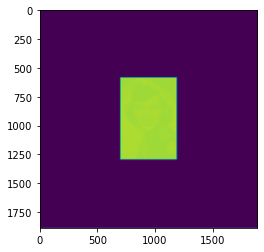

In [262]:
plt.imshow(test_predict_reshaped[:,:,1])

In [263]:
BW_reshaped  = BW[0,:,:,:]

In [264]:
BW_reshaped.shape

(1888, 1888, 1)

In [265]:
print(np.min(BW_reshaped), np.max(BW_reshaped))

0.0017337799 100.0


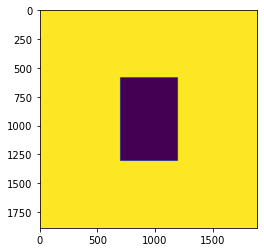

In [266]:
plt.imshow(BW_reshaped)

In [267]:
test_merged_LAB = np.dstack((BW_reshaped, test_predict_reshaped))

In [268]:
test_merged_LAB.shape

(1888, 1888, 3)

In [269]:
print(np.min(test_merged_LAB), np.max(test_merged_LAB))

-0.99908423 100.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


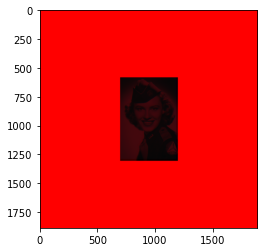

In [270]:
plt.imshow(test_merged_LAB) # show before convert to RGB

In [271]:
#test_merged_LAB= test_merged_LAB*128 # do we need this?

In [272]:
#test_merged_rgb = cv2.cvtColor(test_merged, cv2.COLOR_RGB2Lab) #convert to RGB with cv2
test_merged_rgb = color.lab2rgb(test_merged_LAB) # convert to RGB with skimage

In [273]:
print(np.min(test_merged_rgb), np.max(test_merged_rgb))

0.0 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


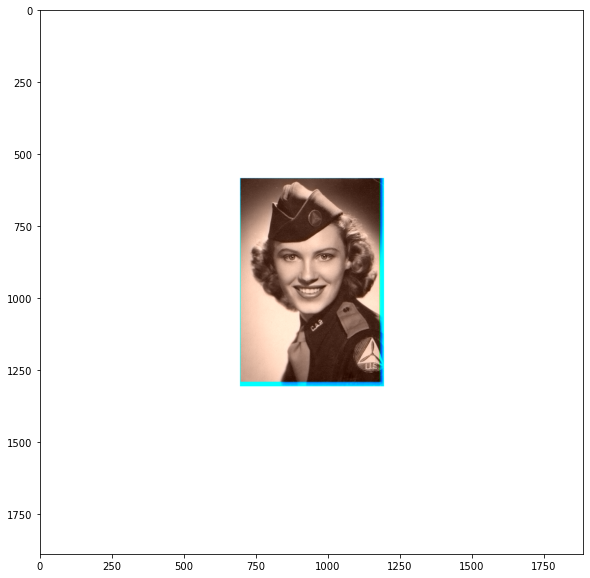

In [274]:
test_merged_rgb = test_merged_rgb*255
plt.figure(figsize=(10, 10))
plt.imshow(test_merged_rgb) #need to RGB need to be scaled before showing after converted from LAB

In [275]:
print(np.min(test_merged_rgb), np.max(test_merged_rgb))

0.0 255.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


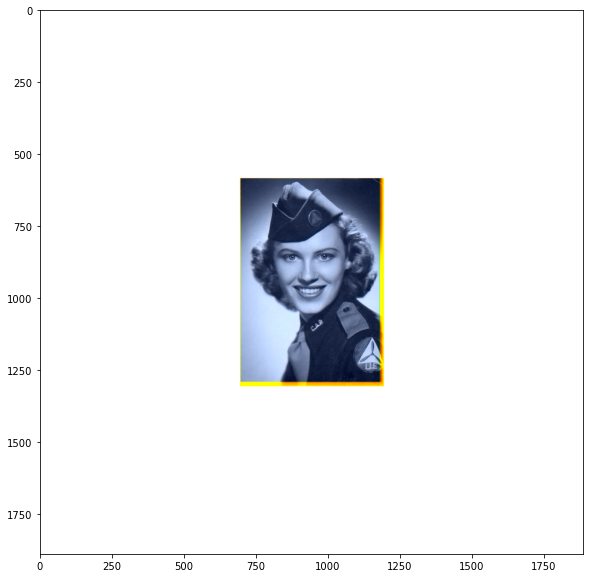

In [276]:
plt.figure(figsize=(10, 10))
plt.imshow(np.flip(test_merged_rgb, -1))

In [277]:
#for_save = np.float16(test_merged_rgb/255)
for_save = np.uint8(test_merged_rgb)
#print(np.min(for_save), np.max(for_save))
io.imsave('result2_Test_model1.jpg', for_save) #